# 📘 ZettaLab - Análise Socioeconômica da Amazônia Legal

Este notebook reúne todos os códigos utilizados no projeto de análise dos impactos socioeconômicos na Amazônia Legal, conforme solicitado.

**Objetivo:** O fluxo de trabalho foi reorganizado para seguir uma estrutura lógica:
1.  **Configuração:** Importar todas as bibliotecas.
2.  **Aquisição de Dados:** Carregar ou baixar os dados brutos.
3.  **Tratamento e Limpeza:** Processar cada fonte de dado individualmente, salvando-as na pasta `data/limpos/`.
4.  **Consolidação:** Unir todas as bases limpas em um único DataFrame.
5.  **Análise e Validação:** Gerar visualizações e validar a base final.

### ETAPA 1: Configuração do Ambiente

Primeiro, vamos importar **todas** as bibliotecas que usaremos no projeto em um único local. Também criamos o diretório `data/limpos` para organizar os arquivos processados.

In [9]:
# Importações de bibliotecas padrão
import os
import re
import glob

# Bibliotecas de manipulação de dados
import pandas as pd
import geopandas as gpd

# Bibliotecas de visualização
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import numpy as np
# --- Configurações Iniciais ---

# Define a pasta para salvar os arquivos tratados
PASTA_LIMPOS = "data/limpos"
os.makedirs(PASTA_LIMPOS, exist_ok=True)

# Lista de estados da Amazônia Legal (usada várias vezes)
AMAZONIA_LEGAL_UFS = ["AC", "AM", "AP", "MA", "MT", "PA", "RO", "RR", "TO"]

print(f"Bibliotecas importadas. Arquivos limpos serão salvos em: {PASTA_LIMPOS}")

Bibliotecas importadas. Arquivos limpos serão salvos em: data/limpos


### ETAPA 2: Aquisição de Dados (Dados Brutos)

Nesta etapa, vamos carregar os dados brutos de suas fontes originais (shapefiles, CSVs locais ou APIs da web).

#### 2.1 Carga - Desmatamento (PRODES)

Carregamos o shapefile principal do PRODES, que contém os polígonos de desmatamento.

In [7]:
# Caminho do shapefile
caminho = "data/base/PRODES_AMZ_Municipal_2023.shp"

# Ler o shapefile
gdf = gpd.read_file(caminho)

print("Colunas encontradas no shapefile:")
print(gdf.columns)

# Salvar como CSV
gdf.to_csv('data/base/desmatamento_por_estado.csv', index=False)

print("✅ Arquivo CSV agregado salvo com sucesso em data/desmatamento_por_estado.csv")


C:\Users\Cliente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:198: RuntimeWarning: data/base/PRODES_AMZ_Municipal_2023.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Colunas encontradas no shapefile:
Index(['fid', 'state', 'path_row', 'main_class', 'class_name', 'sub_class',
       'def_cloud', 'julian_day', 'image_date', 'year', 'area_km', 'scene_id',
       'source', 'satellite', 'sensor', 'uuid', 'geometry'],
      dtype='object')
✅ Arquivo CSV agregado salvo com sucesso em data/desmatamento_por_estado.csv


#### 2.2 Carga - População (IBGE)

Carregamos a base local do IBGE que contém a população por município.

In [9]:
# Caminho do CSV de população
caminho_populacao = "data/base/br_ibge_populacao_municipio.csv"

print(f"Carregando CSV de população de {caminho_populacao}...")
df_populacao_bruto = pd.read_csv(caminho_populacao)

print("CSV de população carregado.")

Carregando CSV de população de data/base/br_ibge_populacao_municipio.csv...
CSV de população carregado.


#### 2.3 Carga - IDH (IPEA)

Carregamos a base local do IPEA que contém o IDH por estado (em formato "wide").

In [10]:
# Caminho do CSV do IDH
caminho_idh = "data/base/ipeadata[24-10-2025-01-26].csv"

print(f"Carregando CSV do IDH de {caminho_idh}...")
# Pulamos a primeira linha (skiprows=1) que parece ser um cabeçalho extra no arquivo original
df_idh_bruto = pd.read_csv(caminho_idh, skiprows=1)

print("CSV de IDH carregado.")

Carregando CSV do IDH de data/base/ipeadata[24-10-2025-01-26].csv...
CSV de IDH carregado.


#### 2.4 Aquisição - PIB (IBGE SIDRA)

Aqui, fazemos o download dos dados do PIB de 2017 a 2021 diretamente da API do SIDRA (IBGE).

In [12]:
# Anos de interesse
anos_pib = [2017, 2018, 2019, 2020, 2021]

print("Iniciando download dos dados do PIB (IBGE SIDRA)...")

for ano in anos_pib:
    print(f"Baixando dados de {ano}...")
    
    # URL da API SIDRA para o PIB municipal
    url = f"https://apisidra.ibge.gov.br/values/t/5938/n6/all/v/37/p/{ano}"
    df_pib = pd.read_json(url)
    
    # Salvar o arquivo bruto
    output_path = f"data/base/pib_municipal_{ano}.csv"
    df_pib.to_csv(output_path, index=False)

print("✅ Download dos dados brutos do PIB concluído!")

Iniciando download dos dados do PIB (IBGE SIDRA)...
Baixando dados de 2017...
Baixando dados de 2018...
Baixando dados de 2019...
Baixando dados de 2020...
Baixando dados de 2021...
✅ Download dos dados brutos do PIB concluído!


### ETAPA 3: Tratamento e Limpeza (Data Cleaning)

Agora, processamos cada dado bruto individualmente. O objetivo é filtrar, agregar por Estado/Ano e salvar um arquivo limpo em `data/limpos/`.

#### 3.1 Tratamento - Desmatamento

Vamos agregar os dados do shapefile por estado e ano, e salvar como um CSV limpo.

In [17]:
# Caminho da base original
caminho = "data/base/desmatamento_por_estado.csv"

# Criar pasta de saída
os.makedirs("data/limpos", exist_ok=True)

# 1️⃣ Ler a base
df = pd.read_csv(caminho)
print("✅ Base carregada com sucesso!")
print("📊 Linhas:", len(df))

# 2️⃣ Manter apenas colunas importantes
colunas_importantes = [
    "state",
    "year",
    "area_km"
]
df = df[colunas_importantes]
print("🔹 Colunas mantidas:", list(df.columns))

df = df.rename(columns={
    "state": "UF",
    "year": "ano"
})
# 3️⃣ Corrigir tipos de dados
df["area_km"] = pd.to_numeric(df["area_km"], errors="coerce")

# 4️⃣ Filtrar apenas registros de 2021 entre 2017 
df = df.loc[(df["ano"] >= 2017)&(df["ano"] <= 2021)]

# 5️⃣ Remover linhas com dados inválidos
df = df.dropna(subset=["area_km", "ano"])
# 6️⃣ Agregar total de área desmatada por estado
df_estado = df.groupby(["UF","ano"], as_index=False)["area_km"].sum()

# 7️⃣ Salvar versão agregada
output = "data/limpos/desmatamento_2017-2021.csv"
df_estado.to_csv(output, index=False, encoding="utf-8-sig")

print("✅ Base agregada por estado salva com sucesso!")



✅ Base carregada com sucesso!
📊 Linhas: 801333
🔹 Colunas mantidas: ['state', 'year', 'area_km']
✅ Base agregada por estado salva com sucesso!


#### 3.2 Tratamento - População

Vamos agregar os dados de população por estado e ano.

In [ ]:
# Caminho da base original
caminho = "data/base/br_ibge_populacao_municipio.csv"

# Criar pasta de saída
os.makedirs("data/limpos", exist_ok=True)

# 1️⃣ Ler a base
df = pd.read_csv(caminho)
print("✅ Base carregada com sucesso!")
print("📊 Linhas:", len(df))

# 2️⃣ Manter apenas colunas importantes
colunas_importantes = [
    "ano",
    "sigla_uf",
    "populacao"
]
df = df[colunas_importantes]
print("🔹 Colunas mantidas:", list(df.columns))

df = df.rename(columns={
    "sigla_uf": "UF"
})
# 3️⃣ Corrigir tipos de dados
df["ano"] = pd.to_numeric(df["ano"], errors="coerce")
df["populacao"] = pd.to_numeric(df["populacao"], errors="coerce")

# 4️⃣ Filtrar apenas registros de 2021 (sem criar coluna year permanente)
df = df.loc[(df["ano"] >= 2017) & (df["ano"] <= 2021)]

# 5️⃣ Remover linhas com dados inválidos
df = df.dropna(subset=["populacao"])

amazonia_legal = ["AC", "AM", "AP", "MA", "MT", "PA", "RO", "RR", "TO"]
df= df[df["UF"].isin(amazonia_legal)]
# 6️⃣ Agregar total de área desmatada por estado
df_estado = df.groupby(["UF","ano"], as_index=False)["populacao"].sum()


# 7️⃣ Salvar versão agregada
output = "data/limpos/populacao_estadual_2017-2021.csv"
df_estado.to_csv(output, index=False, encoding="utf-8-sig")

print("✅ Base agregada por estado salva com sucesso!")


✅ Base carregada com sucesso!
📊 Linhas: 174388
🔹 Colunas mantidas: ['ano', 'sigla_uf', 'populacao']
✅ Base agregada por estado salva com sucesso!


#### 3.3 Tratamento - IDH

Vamos transformar os dados de IDH do formato "wide" (anos em colunas) para "long" (uma coluna 'ano' e uma 'IDH').

In [29]:
# Caminho da base original
caminho = "data/base/ipeadata[24-10-2025-01-26].csv"

# Criar pasta de saída
os.makedirs("data/limpos", exist_ok=True)

# 1️⃣ Ler a base
df = pd.read_csv(caminho, skiprows=1)
print("✅ Base carregada com sucesso!")
print("📊 Linhas:", len(df))

# 2️⃣ Manter apenas colunas importantes
colunas_importantes = ["Sigla", "2017", "2018", "2019", "2020", "2021"]
df = df[colunas_importantes]
print("🔹 Colunas mantidas:", list(df.columns))

# Renomear colunas
df = df.rename(columns={"Sigla": "UF"})

# 3️⃣ Converter anos para numérico
for ano in ["2017", "2018", "2019", "2020", "2021"]:
    df[ano] = pd.to_numeric(df[ano], errors="coerce")

# 4️⃣ Filtrar apenas Amazônia Legal
amazonia_legal = ["AC", "AM", "AP", "MA", "MT", "PA", "RO", "RR", "TO"]
df = df[df["UF"].isin(amazonia_legal)]

# 5️⃣ “Derreter” (transformar colunas em linhas)
df_melt = df.melt(
    id_vars=["UF"],                # o que permanece fixo
    value_vars=["2017", "2018", "2019", "2020", "2021"],  # o que vira linhas
    var_name="ano",                # nome da nova coluna
    value_name="IDH"               # nome dos valores
)

# 6️⃣ Converter ano pra inteiro
df_melt["ano"] = df_melt["ano"].astype(int)

# 7️⃣ Salvar resultado final
output = "data/limpos/ipeadata_idh_2017-2021.csv"
df_melt.to_csv(output, index=False, encoding="utf-8-sig")

print("✅ Base transformada e salva com sucesso!")


✅ Base carregada com sucesso!
📊 Linhas: 27
🔹 Colunas mantidas: ['Sigla', '2017', '2018', '2019', '2020', '2021']
✅ Base transformada e salva com sucesso!


#### 3.4 Tratamento - PIB (Consolidado)

Aqui, vamos iterar sobre todos os CSVs de PIB que baixamos (2017-2021), limpá-los e uni-los em um único arquivo.

In [36]:
print("Iniciando processamento consolidado dos arquivos de PIB...")

# Encontrar todos os arquivos de PIB brutos que baixamos na Etapa 2
arquivos_pib_brutos = glob.glob("data/base/pib_municipal_*.csv")

lista_dfs_pib_limpos = []

for arquivo in arquivos_pib_brutos:
    print(f"Processando {arquivo}...")
    df_pib = pd.read_csv(arquivo, encoding="utf-8")
    
    # Renomear colunas relevantes (conforme API do SIDRA)
    df_pib = df_pib.rename(columns={
        "V": "pib_mil_reais",
        "D1N": "municipio",
        "D3N": "ano"
    })
    
    # Extrair a sigla do estado (UF) a partir do nome do município
    # Ex: "Alta Floresta D'Oeste - RO" -> "RO"
    df_pib["UF"] = df_pib["municipio"].apply(
        lambda x: re.search(r"-\s*([A-Z]{2})$", x).group(1)
        if isinstance(x, str) and re.search(r"-\s*([A-Z]{2})$", x)
        else None
    )
    
    # Converter valores para numérico
    df_pib["pib_mil_reais"] = pd.to_numeric(df_pib["pib_mil_reais"], errors="coerce")
    
    # Filtrar apenas estados da Amazônia Legal
    df_pib = df_pib[df_pib["UF"].isin(AMAZONIA_LEGAL_UFS)]
    
    # Agrupar por estado e ano, somando o PIB
    pib_estadual = df_pib.groupby(["UF", "ano"], as_index=False)["pib_mil_reais"].sum()
    
    lista_dfs_pib_limpos.append(pib_estadual)

# Consolidar todos os anos em um DataFrame
df_pib_final = pd.concat(lista_dfs_pib_limpos, ignore_index=True)

# Adicionar PIB em bilhões para facilitar leitura e análise
df_pib_final["pib_bilhoes"] = (df_pib_final["pib_mil_reais"] / 1_000_000).round(2)

# Ordenar por ano e estado
df_pib_final = df_pib_final.sort_values(by=["ano", "UF"]).reset_index(drop=True)

# Salvar o resultado
output_pib = os.path.join(PASTA_LIMPOS, "pib_estadual_amazonia_2017_2021.csv")
df_pib_final.to_csv(output_pib, index=False, encoding="utf-8-sig")

print(f"✅ Arquivo PIB consolidado (2017-2021) salvo em: {output_pib}")

Iniciando processamento consolidado dos arquivos de PIB...
Processando data/base\pib_municipal_2017.csv...
Processando data/base\pib_municipal_2018.csv...
Processando data/base\pib_municipal_2019.csv...
Processando data/base\pib_municipal_2020.csv...
Processando data/base\pib_municipal_2021.csv...
✅ Arquivo PIB consolidado (2017-2021) salvo em: data/limpos\pib_estadual_amazonia_2017_2021.csv


### ETAPA 4: Consolidação e Validação da Base Final

Com todos os dados limpos e agregados por UF/Ano, podemos agora uni-los em uma única base de análise.

#### 4.1 Junção (Merge) dos Dados

In [31]:
print("Iniciando a consolidação da base final...")

# Carregar todas as bases limpas que acabamos de criar
pop = pd.read_csv(os.path.join(PASTA_LIMPOS, "populacao_estadual_2017-2021.csv"))
desm = pd.read_csv(os.path.join(PASTA_LIMPOS, "desmatamento_2017-2021.csv"))
idh = pd.read_csv(os.path.join(PASTA_LIMPOS, "ipeadata_idh_2017-2021.csv"))
pib = pd.read_csv(os.path.join(PASTA_LIMPOS, "pib_estadual_amazonia_2017_2021.csv"))

# Merge progressivo, usando 'UF' e 'ano' como chaves
df_final = pop.merge(desm, on=["UF", "ano"]) \
              .merge(idh, on=["UF", "ano"]) \
              .merge(pib, on=["UF", "ano"])

# Renomear 'area_km' para maior clareza
df_final = df_final.rename(columns={"area_km": "area_desmatada_km"})

# Salvar a base final pronta para análise/modelagem
output_final = os.path.join(PASTA_LIMPOS, "base_final_analise.csv")
df_final.to_csv(output_final, index=False, encoding="utf-8-sig")

print("✅ Base final criada com sucesso!")

Iniciando a consolidação da base final...
✅ Base final criada com sucesso!


#### 4.2 Validação da Base Final

Vamos fazer uma verificação rápida para garantir que a base está pronta (sem nulos, tipos corretos).

In [32]:
# Carregar a base final para verificação
df = pd.read_csv(output_final)

print(f"📊 Dimensões da base final: {df.shape}")
print("\n🔹 Colunas e tipos de dados:")
print(df.dtypes)

print("\n🔍 Valores nulos por coluna:")
print(df.isnull().sum())

# Conferir se todas as colunas numéricas são válidas
if not df.isnull().values.any():
    print("\n✅ Base final está completa e sem valores nulos.")
else:
    print("\n⚠️ Atenção: Existem valores nulos na base final.")

📊 Dimensões da base final: (45, 7)

🔹 Colunas e tipos de dados:
UF                    object
ano                    int64
populacao            float64
area_desmatada_km    float64
IDH                  float64
pib_mil_reais        float64
pib_bilhoes          float64
dtype: object

🔍 Valores nulos por coluna:
UF                   0
ano                  0
populacao            0
area_desmatada_km    0
IDH                  0
pib_mil_reais        0
pib_bilhoes          0
dtype: int64

✅ Base final está completa e sem valores nulos.


### ETAPA 5: Análise e Visualização

Finalmente, usamos a base consolidada para gerar as visualizações e análises de correlação.

### 5.1 : Criação de gráficos de correlação entre as colunas com o desmatamento 

Gerando gráficos de correlação (Regressão Linear)...


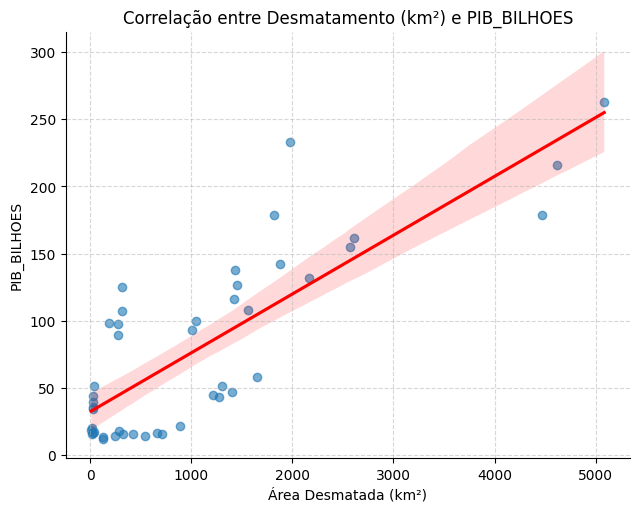

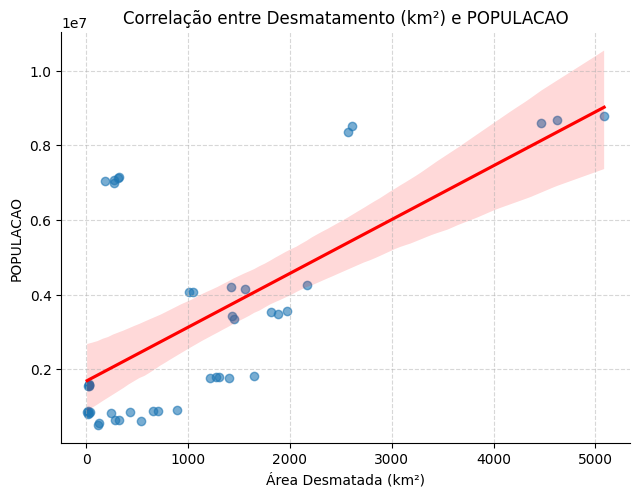

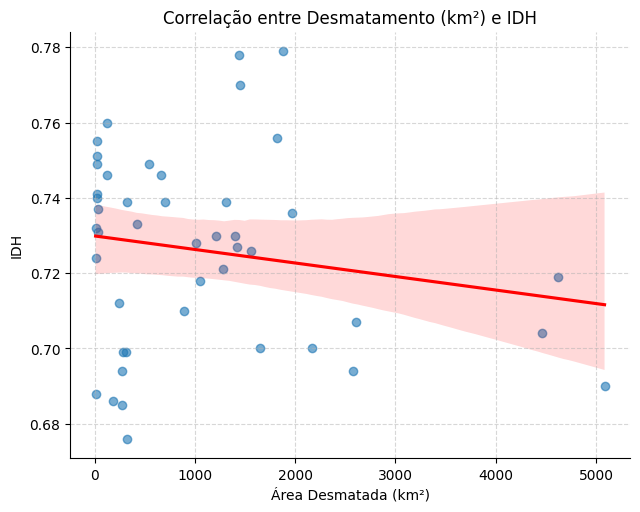

Análise concluída.


In [33]:
print("Gerando gráficos de correlação (Regressão Linear)...")

# Ler a base final
df_analise = pd.read_csv(os.path.join(PASTA_LIMPOS, "base_final_analise.csv"))

# Variáveis para comparar com o desmatamento
variaveis_socioeconomicas = ["pib_bilhoes", "populacao", "IDH"]

# Gerar um gráfico com reta de regressão para cada variável
for var in variaveis_socioeconomicas:
    
    # Usar o Seaborn lmplot para ver a correlação e a linha de regressão
    sns.lmplot(
        data=df_analise, 
        x="area_desmatada_km", 
        y=var, 
        height=5, 
        aspect=1.3, 
        scatter_kws={'alpha':0.6},  # Pontos semitransparentes
        line_kws={'color':'red'}    # Linha de regressão vermelha
    )
    
    plt.title(f"Correlação entre Desmatamento (km²) e {var.upper()}")
    plt.xlabel("Área Desmatada (km²)")
    plt.ylabel(var.upper())
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Mostrar o gráfico
    plt.show()

print("Análise concluída.")

### 5.2 : Criação do gráfico heatmap(Mostrando a relação entre todas as colunas)

Próximo de 1: proporcional

Próximo de -1: inversamentes proporcionais

Próximo de 0: correlação baixa

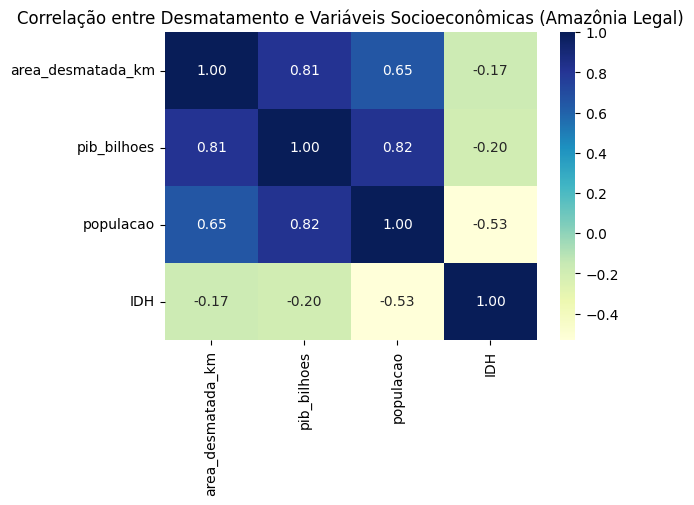

In [35]:
# 1. Ler a base
df = pd.read_csv("data/limpos/base_final_analise.csv")

# 2. Selecionar apenas as colunas numéricas relevantes
cols = ["area_desmatada_km", "pib_bilhoes", "populacao", "IDH"]
corr = df[cols].corr()

# 3. Gerar o mapa de calor
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlação entre Desmatamento e Variáveis Socioeconômicas (Amazônia Legal)")
plt.show()


### 5.3 Criação da visulização dos datasets iniciais

In [31]:
import pandas as pd
import dataframe_image as dfi

df = pd.read_csv("data/limpos/populacao_estadual_2017-2021.csv")

chrome_path = "C:/Program Files/Google/Chrome/Application/chrome.exe"

dfi.export(
    df.head(10),
    "analises/imgs/amostras/limpos/amostra_populacao_limpo.png",
    table_conversion="chrome",
    chrome_path=chrome_path
)

print("✅ Imagem gerada com sucesso!")


✅ Imagem gerada com sucesso!


### ETAPA 6: Previsão de IDH e PIB dos anos 2022-2024 

Nesta etapa, utilizamos os **dados históricos (2017–2021)** da base unificada (`base_final_analise.csv`) e os **dados de desmatamento real/projetado (2022–2024)** para estimar o comportamento futuro do **PIB** e do **IDH** na Amazônia Legal.

A abordagem é baseada em **Regressão Linear**, onde:

- As variáveis **ano** e **área desmatada (`area_km`)** são utilizadas como preditoras;
- São ajustados dois modelos independentes:  
  1. **PIB ~ ano + area_km**  
  2. **IDH ~ ano + area_km**
- O objetivo é entender como a variação no desmatamento influencia o crescimento econômico e o desenvolvimento humano nos anos seguintes.

As previsões são geradas para cada estado da Amazônia Legal e salvas no arquivo:

> 📁 `analises/previsoes_desmatamento_base.csv`

In [ ]:

# Caminho da base original
caminho = "data/base/desmatamento_por_estado.csv"

# Criar pasta de saída
os.makedirs("data/limpos", exist_ok=True)

# 1️⃣ Ler a base
df = pd.read_csv(caminho)
print("✅ Base carregada com sucesso!")
print("📊 Linhas:", len(df))

# 2️⃣ Manter apenas colunas importantes
colunas_importantes = [
    "state",
    "year",
    "area_km"
]
df = df[colunas_importantes]
print("🔹 Colunas mantidas:", list(df.columns))

df = df.rename(columns={
    "state": "UF",
    "year": "ano",
    "area_km": "area_desmatada_km"
})
# 3️⃣ Corrigir tipos de dados
df["area_desmatada_km"] = pd.to_numeric(df["area_desmatada_km"], errors="coerce")

# 4️⃣ Filtrar apenas registros de 2021 entre 2017 
df = df.loc[(df["ano"] >= 2022)&(df["ano"] <= 2024)]

# 5️⃣ Remover linhas com dados inválidos
df = df.dropna(subset=["area_desmatada_km", "ano"])
# 6️⃣ Agregar total de área desmatada por estado
df_estado = df.groupby(["UF","ano"], as_index=False)["area_desmatada_km"].sum()

# 7️⃣ Salvar versão agregada
output = "data/limpos/desmatamento_2021_posteriores.csv"
df_estado.to_csv(output, index=False, encoding="utf-8-sig")

print("✅ Base agregada por estado salva com sucesso!")



# 1️⃣ Ler as bases
base = pd.read_csv("data/limpos/base_final_analise.csv")
desmate_futuro = pd.read_csv("data/limpos/desmatamento_2021_posteriores.csv")

# 2️⃣ Padronizar colunas
base.rename(columns={"UF": "UF", "ano": "ano", "area_desmatada_km": "area_desmatada_km"}, inplace=True)
desmate_futuro.rename(columns={"UF": "UF", "ano": "ano", "area_desmatada_km": "area_desmatada_km"}, inplace=True)

# 3️⃣ Criar lista para armazenar previsões
previsoes = []

# 4️⃣ Loop por estado (UF)
for uf in base["UF"].unique():
    subset = base[base["UF"] == uf].dropna(subset=["pib_bilhoes", "IDH", "area_desmatada_km"])
    X = subset[["ano", "area_desmatada_km"]]
    
    # Modelos separados para PIB e IDH
    modelo_pib = LinearRegression().fit(X, subset["pib_bilhoes"])
    modelo_idh = LinearRegression().fit(X, subset["IDH"])
    
    # Dados futuros do desmatamento
    fut = desmate_futuro[desmate_futuro["UF"] == uf]
    if fut.empty:
        continue

    X_fut = fut[["ano", "area_desmatada_km"]]
    
    # Previsões
    fut["pib_previsto"] = modelo_pib.predict(X_fut)
    fut["idh_previsto"] = modelo_idh.predict(X_fut)
    
    previsoes.append(fut[["UF", "ano", "area_desmatada_km", "pib_previsto", "idh_previsto"]])

# 5️⃣ Concatenar e salvar
df_prev = pd.concat(previsoes)
df_prev.to_csv("analises/previsoes_desmatamento_base.csv", index=False)
print("✅ Previsões geradas e salvas em previsoes_desmatamento_base.csv")



✅ Base carregada com sucesso!
📊 Linhas: 801333
🔹 Colunas mantidas: ['state', 'year', 'area_km']
✅ Base agregada por estado salva com sucesso!
✅ Previsões geradas e salvas em previsoes_desmatamento_base.csv


C:\Users\Cliente\AppData\Local\Temp\ipykernel_24272\2372523373.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fut["pib_previsto"] = modelo_pib.predict(X_fut)
C:\Users\Cliente\AppData\Local\Temp\ipykernel_24272\2372523373.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fut["idh_previsto"] = modelo_idh.predict(X_fut)
C:\Users\Cliente\AppData\Local\Temp\ipykernel_24272\2372523373.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind